Here's a step-by-step guide to develop your ASL Alphabet Recognition project using the ASL Alphabet Dataset:

### **Step 1: Setup Project Environment**
1. **Create Project Directory**
   ```bash
   mkdir asl-recognition
   cd asl-recognition
   ```

2. **Set Up Virtual Environment**
   ```bash
   python -m venv venv
   source venv/bin/activate  # Linux/Mac
   # OR
   venv\Scripts\activate  # Windows
   ```

3. **Install Required Libraries**
   ```bash
   pip install tensorflow opencv-python matplotlib numpy pillow flask gunicorn
   ```

---

### **Step 2: Download & Prepare Dataset**
1. **Download ASL Alphabet Dataset**  
   - Get it from [Kaggle](https://www.kaggle.com/datasets/grassknoted/asl-alphabet)
   - Extract into `dataset/` folder.

2. **Dataset Structure**
   ```
   dataset/
   └── asl_alphabet_train/
       ├── A/      # Images of 'A' sign
       ├── B/      # Images of 'B' sign
       ...
       └── space/  # Images of 'space' sign
   ```

3. **Split into Train/Test Sets**  
   Create `preprocess.py`:
   ```python
   import os
   import shutil
   from sklearn.model_selection import train_test_split

   # Paths
   dataset_path = "dataset/asl_alphabet_train"
   train_path = "dataset/train"
   test_path = "dataset/test"
   test_size = 0.2  # 20% for testing

   # Create train/test directories
   os.makedirs(train_path, exist_ok=True)
   os.makedirs(test_path, exist_ok=True)

   # Split each class
   for class_name in os.listdir(dataset_path):
       class_path = os.path.join(dataset_path, class_name)
       images = os.listdir(class_path)
       
       # Split images
       train_imgs, test_imgs = train_test_split(images, test_size=test_size, random_state=42)
       
       # Copy to train/test folders
       os.makedirs(os.path.join(train_path, class_name), exist_ok=True)
       os.makedirs(os.path.join(test_path, class_name), exist_ok=True)
       
       for img in train_imgs:
           shutil.copy(os.path.join(class_path, img), os.path.join(train_path, class_name, img))
       for img in test_imgs:
           shutil.copy(os.path.join(class_path, img), os.path.join(test_path, class_name, img))
   ```
   Run:
   ```bash
   python preprocess.py
   ```

---

### **Step 3: Build & Train the Model**
1. **Create `train.py`**
   ```python
   import tensorflow as tf
   from tensorflow.keras.preprocessing.image import ImageDataGenerator

   # Parameters
   IMG_SIZE = (64, 64)
   BATCH_SIZE = 32
   EPOCHS = 15

   # Data Augmentation
   train_datagen = ImageDataGenerator(
       rescale=1./255,
       rotation_range=10,
       zoom_range=0.1,
       width_shift_range=0.1,
       height_shift_range=0.1,
       horizontal_flip=True,
       validation_split=0.2
   )

   # Load data
   train_generator = train_datagen.flow_from_directory(
       "dataset/train",
       target_size=IMG_SIZE,
       batch_size=BATCH_SIZE,
       class_mode="categorical",
       subset="training"
   )

   val_generator = train_datagen.flow_from_directory(
       "dataset/train",
       target_size=IMG_SIZE,
       batch_size=BATCH_SIZE,
       class_mode="categorical",
       subset="validation"
   )

   # Model Architecture
   model = tf.keras.Sequential([
       tf.keras.layers.Conv2D(32, (3,3), activation="relu", input_shape=(*IMG_SIZE, 3)),
       tf.keras.layers.MaxPooling2D(2,2),
       tf.keras.layers.Conv2D(64, (3,3), activation="relu"),
       tf.keras.layers.MaxPooling2D(2,2),
       tf.keras.layers.Conv2D(128, (3,3), activation="relu"),
       tf.keras.layers.MaxPooling2D(2,2),
       tf.keras.layers.Flatten(),
       tf.keras.layers.Dense(256, activation="relu"),
       tf.keras.layers.Dense(29, activation="softmax")  # 29 classes (A-Z + space, del, nothing)
   ])

   model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

   # Train
   history = model.fit(
       train_generator,
       validation_data=val_generator,
       epochs=EPOCHS
   )

   # Save model
   model.save("asl_model.h5")
   ```

2. **Run Training**
   ```bash
   python train.py
   ```

---

### **Step 4: Test the Model**
1. **Create `test.py`**
   ```python
   import cv2
   import numpy as np
   from tensorflow.keras.models import load_model

   # Load model
   model = load_model("asl_model.h5")

   # Class names
   class_names = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
                 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z',
                 'del', 'nothing', 'space']

   # Test on a sample image
   def predict_image(img_path):
       img = cv2.imread(img_path)
       img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
       img = cv2.resize(img, (64, 64))
       img = img / 255.0
       img = np.expand_dims(img, axis=0)
       
       pred = model.predict(img)
       predicted_class = class_names[np.argmax(pred)]
       confidence = np.max(pred) * 100
       
       print(f"Predicted: {predicted_class} ({confidence:.2f}%)")

   # Test
   predict_image("dataset/test/A/1.jpg")
   ```

2. **Run Testing**
   ```bash
   python test.py
   ```

---

### **Step 5: Build Flask API**
1. **Create `app.py`**
   ```python
   from flask import Flask, request, jsonify
   import cv2
   import numpy as np
   from tensorflow.keras.models import load_model

   app = Flask(__name__)
   model = load_model("asl_model.h5")
   class_names = ['A', 'B', 'C', ..., 'space']  # Same as before

   @app.route("/predict", methods=["POST"])
   def predict():
       if "file" not in request.files:
           return jsonify({"error": "No file uploaded"}), 400
       
       file = request.files["file"]
       img = cv2.imdecode(np.frombuffer(file.read(), np.uint8), cv2.IMREAD_COLOR)
       img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
       img = cv2.resize(img, (64, 64))
       img = img / 255.0
       img = np.expand_dims(img, axis=0)
       
       pred = model.predict(img)
       predicted_class = class_names[np.argmax(pred)]
       confidence = float(np.max(pred))
       
       return jsonify({
           "prediction": predicted_class,
           "confidence": confidence
       })

   if __name__ == "__main__":
       app.run(debug=True)
   ```

2. **Test API Locally**
   ```bash
   python app.py
   ```
   - Use **Postman** or `curl` to send a POST request:
     ```bash
     curl -X POST -F "file=@test_image.jpg" http://localhost:5000/predict
     ```

---

### **Step 6: Deploy to Vercel**
1. **Create `vercel.json`**
   ```json
   {
     "version": 2,
     "builds": [
       {
         "src": "app.py",
         "use": "@vercel/python"
       }
     ],
     "routes": [
       {
         "src": "/(.*)",
         "dest": "app.py"
       }
     ]
   }
   ```

2. **Deploy**
   - Push to GitHub/GitLab.
   - Connect to Vercel and deploy.

---

### **Final Project Structure**
```
asl-recognition/
├── dataset/
│   ├── train/       # Training images
│   └── test/        # Testing images
├── asl_model.h5     # Trained model
├── app.py           # Flask API
├── train.py         # Training script
├── test.py          # Testing script
├── preprocess.py    # Data splitter
└── vercel.json      # Vercel config
```

### **Next Steps**
- Improve model accuracy with more layers/data augmentation.
- Build a frontend (React/Flask) for real-time webcam predictions.
- Optimize for mobile deployment.


In [12]:
import warnings
warnings.filterwarnings('ignore')

In [13]:
print("Hello World!")

Hello World!


In [14]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())
print(tf.test.gpu_device_name())


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/home/ahmad10raza/anaconda3/envs/sign/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/home/ahmad10raza/anaconda3/envs/sign/lib/python3.9/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/home/ahmad10raza/anaconda3/envs/sign/lib/python3.9/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/home/ahmad10raza/anaconda3/envs/sign/lib/python3.9/site-packages/traitlets/config/application.py",

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/home/ahmad10raza/anaconda3/envs/sign/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/home/ahmad10raza/anaconda3/envs/sign/lib/python3.9/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/home/ahmad10raza/anaconda3/envs/sign/lib/python3.9/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/home/ahmad10raza/anaconda3/envs/sign/lib/python3.9/site-packages/traitlets/config/application.py",

AttributeError: _ARRAY_API not found

ImportError: numpy.core._multiarray_umath failed to import

ImportError: numpy.core.umath failed to import

TypeError: Unable to convert function return value to a Python type! The signature was
	() -> handle

In [ ]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[]

In [4]:
with tf.device('/GPU:0'):
    a = tf.constant([1.0, 2.0, 3.0])
    b = tf.constant([4.0, 5.0, 6.0])
    c = a * b
print(c)

tf.Tensor([ 4. 10. 18.], shape=(3,), dtype=float32)


2025-04-29 12:39:23.135071: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-04-29 12:39:23.135252: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-04-29 12:39:23.135329: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-04-29 12:39:23.135456: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-04-29 12:39:23.135528: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

#  Cell 1: Load dataset

In [1]:
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

dataset_path = "datasets/asl_alphabet_train/asl_alphabet_train"
class_names = sorted(os.listdir(dataset_path))
print("Classes:", class_names)

2025-05-27 00:44:18.350208: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-27 00:44:18.419601: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-27 00:44:18.419648: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-27 00:44:18.421128: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-27 00:44:18.430361: I tensorflow/core/platform/cpu_feature_guar

Classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


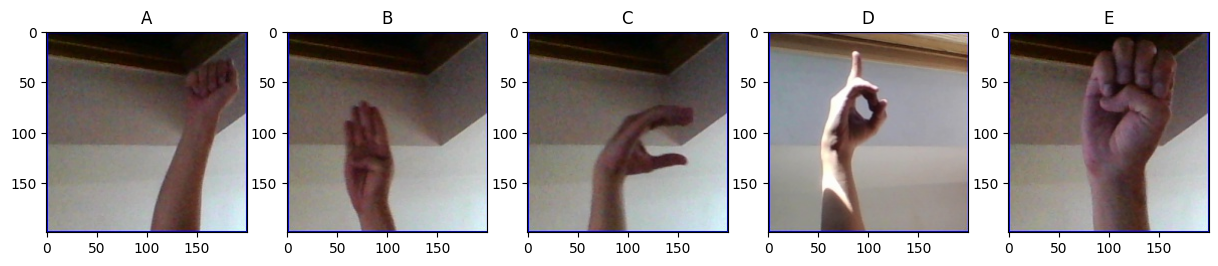

In [2]:
# Cell 2: Visualize samples
plt.figure(figsize=(15,10))
for i, class_name in enumerate(class_names[:5]):
    img_path = os.path.join(dataset_path, class_name, os.listdir(os.path.join(dataset_path, class_name))[0])
    img = plt.imread(img_path)
    plt.subplot(1,5,i+1)
    plt.imshow(img)
    plt.title(class_name)
plt.show()

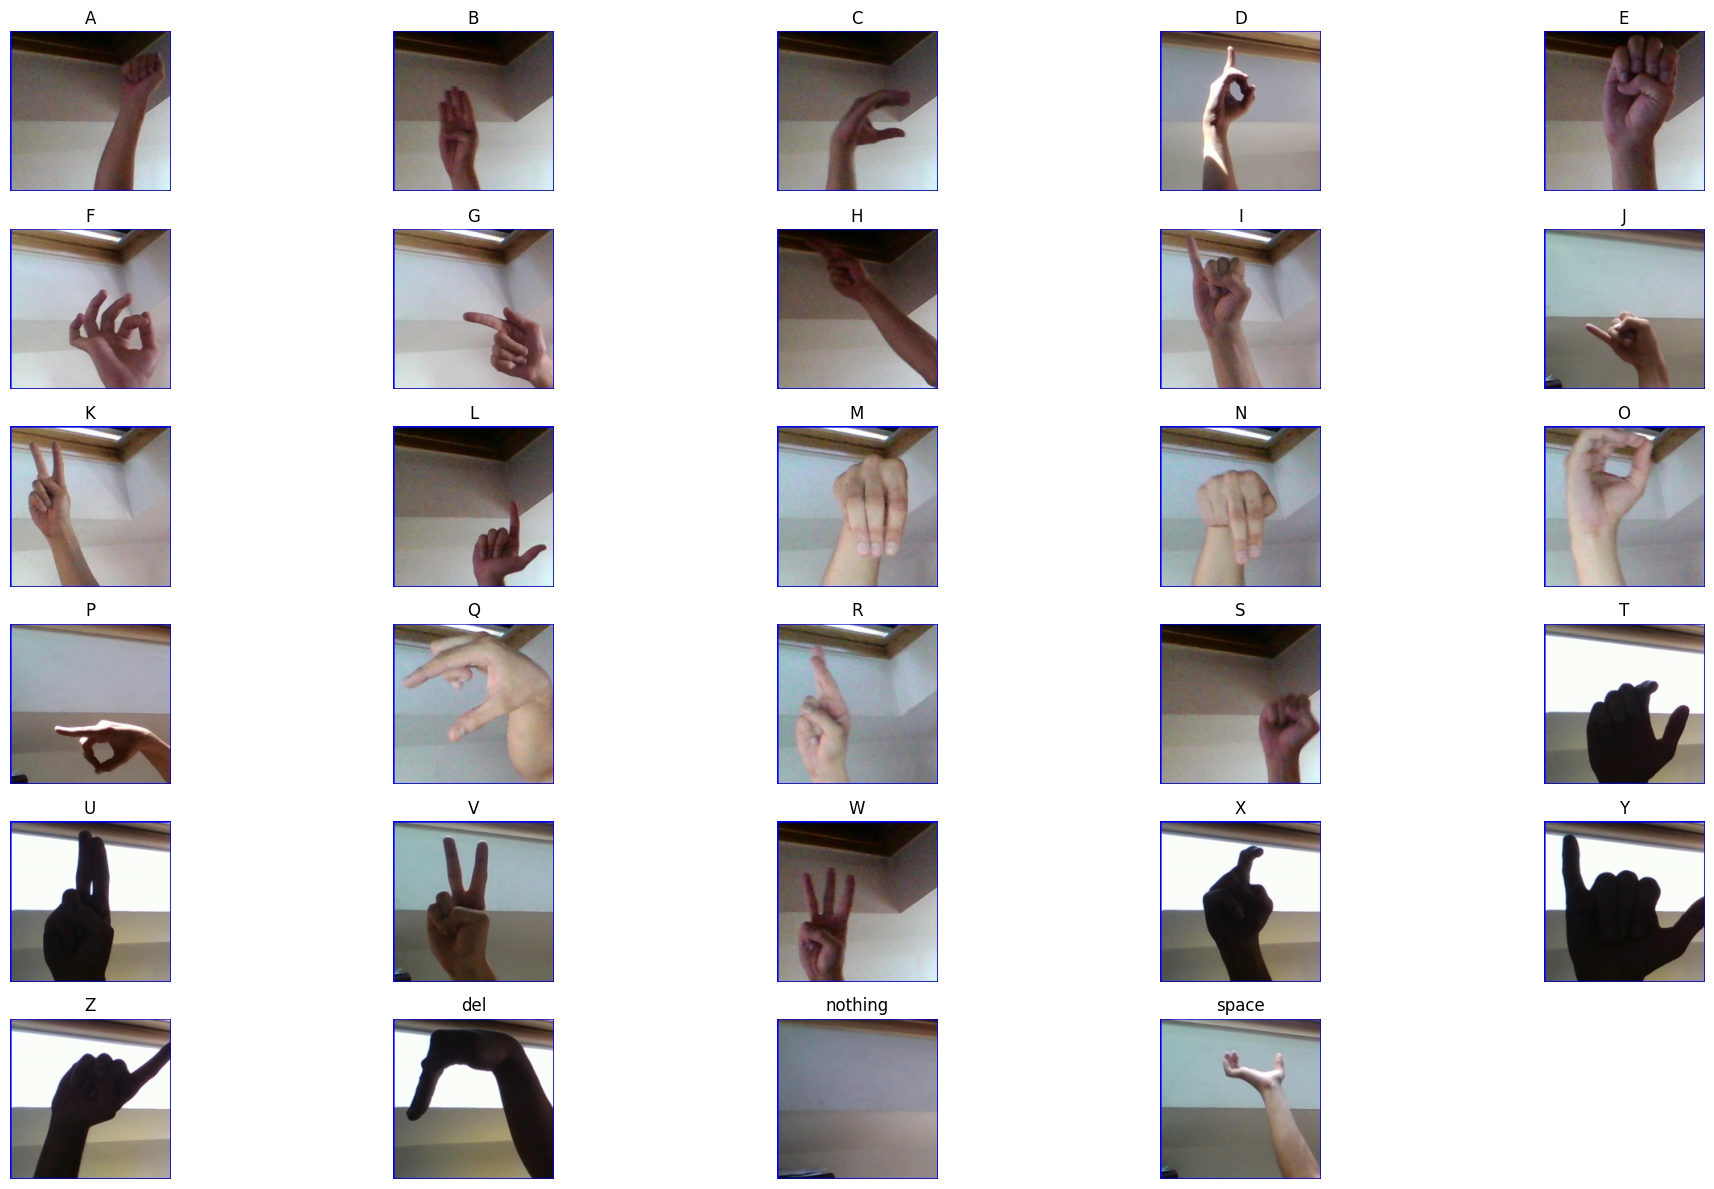

In [3]:
import os
import matplotlib.pyplot as plt

# Assuming dataset_path and class_names are already defined
# Example: class_names = sorted(os.listdir(dataset_path))

plt.figure(figsize=(20, 12))  # Adjust based on how many images per row you want

num_classes = len(class_names)

# Calculate grid size for plotting
cols = 5  # You can adjust this
rows = (num_classes + cols - 1) // cols

for i, class_name in enumerate(class_names):
    img_folder = os.path.join(dataset_path, class_name)
    img_list = os.listdir(img_folder)
    if not img_list:
        continue
    img_path = os.path.join(img_folder, img_list[0])
    img = plt.imread(img_path)
    
    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis('off')

plt.tight_layout()
plt.show()


## Cell 3: Create generators

In [4]:

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

In [5]:
IMG_SIZE = (64, 64)
BATCH_SIZE = 32

train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)


Found 69600 images belonging to 29 classes.


In [7]:
val_generator = train_datagen.flow_from_directory(
    'datasets/asl_alphabet_train/asl_alphabet_train',  # Same dataset path
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'  # Validation subset
)


Found 17400 images belonging to 29 classes.


## 3. Model Building

## Cell 1: Define model architecture

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(29, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0

### Cell 2: Train model

#### Enhanced Model Training with Callbacks

In [14]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Define callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',     # Monitor validation loss
        patience=5,            # Number of epochs with no improvement before stopping
        restore_best_weights=True  # Restores model weights from best epoch
    ),
    ModelCheckpoint(
        filepath='best_model.h5',  # Save best model
        monitor='val_accuracy',    # Track accuracy
        save_best_only=True,
        mode='max'                # Save when accuracy maximizes
    ),
    ReduceLROnPlateau(
        monitor='val_loss',       # Reduce learning rate when loss plateaus
        factor=0.2,              # Reduce LR by 20%
        patience=3,              # Number of epochs with no improvement
        min_lr=1e-6              # Minimum learning rate
    )
]

In [15]:
EPOCHS = 100
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100
2175/2175 [==============================] - 76s 35ms/step - loss: 0.3987 - accuracy: 0.8643 - val_loss: 0.8971 - val_accuracy: 0.7448
Epoch 2/100
2175/2175 [==============================] - 74s 34ms/step - loss: 0.2659 - accuracy: 0.9111 - val_loss: 0.7394 - val_accuracy: 0.7799
Epoch 3/100
2175/2175 [==============================] - 73s 34ms/step - loss: 0.1993 - accuracy: 0.9334 - val_loss: 0.7923 - val_accuracy: 0.7937
Epoch 4/100
2175/2175 [==============================] - 74s 34ms/step - loss: 0.1657 - accuracy: 0.9444 - val_loss: 0.7745 - val_accuracy: 0.8040
Epoch 5/100
2175/2175 [==============================] - 73s 33ms/step - loss: 0.1422 - accuracy: 0.9521 - val_loss: 0.7452 - val_accuracy: 0.8153
Epoch 6/100
2175/2175 [==============================] - 73s 34ms/step - loss: 0.0697 - accuracy: 0.9769 - val_loss: 0.7116 - val_accuracy: 0.8401
Epoch 7/100
2175/2175 [==============================] - 73s 34ms/step - loss: 0.0529 - accuracy: 0.9827 - val_loss: 0

In [17]:
model.save('asl_model.h5')

In [18]:
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

model = load_model('asl_model.h5')


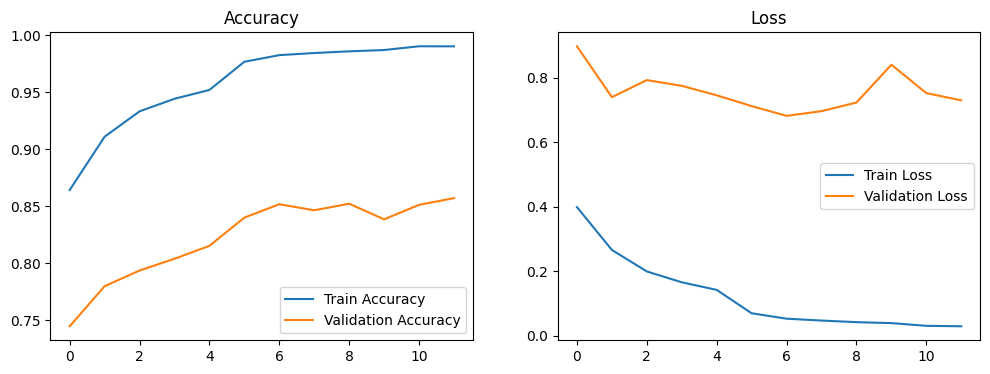

In [19]:
# Cell 2: Plot training history
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()
plt.show()


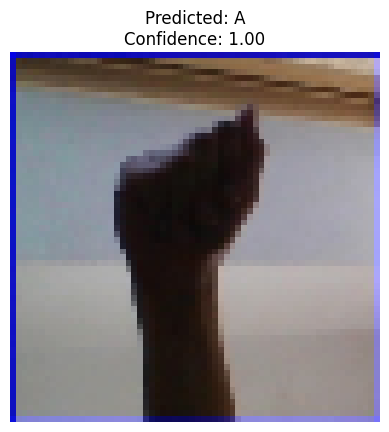

In [20]:
# Cell 3: Test prediction
import cv2
import numpy as np

def predict_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (64,64))
    img = img/255.0
    img = np.expand_dims(img, axis=0)
    
    pred = model.predict(img)
    class_idx = np.argmax(pred)
    confidence = np.max(pred)
    
    plt.imshow(img[0])
    plt.title(f"Predicted: {class_names[class_idx]}\nConfidence: {confidence:.2f}")
    plt.axis('off')
    plt.show()

# Test with sample image
predict_image("datasets/asl_alphabet_train/asl_alphabet_train/A/A1.jpg")


## Enhanced ASL Recognition Model Architecture

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

def create_enhanced_model(input_shape=(64, 64, 3), num_classes=29):
    model = Sequential([
        # Block 1
        Conv2D(64, (3,3), padding='same', activation='relu', 
               kernel_regularizer=l2(0.001), input_shape=input_shape),
        BatchNormalization(),
        Conv2D(64, (3,3), padding='same', activation='relu',
               kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPooling2D(2,2),
        Dropout(0.3),
        
        # Block 2
        Conv2D(128, (3,3), padding='same', activation='relu',
               kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Conv2D(128, (3,3), padding='same', activation='relu',
               kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPooling2D(2,2),
        Dropout(0.3),
        
        # Block 3
        Conv2D(256, (3,3), padding='same', activation='relu',
               kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Conv2D(256, (3,3), padding='same', activation='relu',
               kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPooling2D(2,2),
        Dropout(0.3),
        
        # Block 4
        Conv2D(512, (3,3), padding='same', activation='relu',
               kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Conv2D(512, (3,3), padding='same', activation='relu',
               kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        GlobalAveragePooling2D(),
        
        # Classifier
        Dense(1024, activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.5),
        Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    
    # Custom optimizer configuration
    optimizer = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999)
    
    model.compile(optimizer=optimizer,
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])
    
    return model

# Create model
enhanced_model = create_enhanced_model()
enhanced_model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 64)        1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       7

2025-04-29 14:46:35.761361: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-04-29 14:46:35.761648: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-04-29 14:46:35.761788: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-04-29 14:46:35.761978: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-04-29 14:46:35.762103: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [11]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7),
    ModelCheckpoint('best_enhanced_model.h5', save_best_only=True)
]

history = enhanced_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100,
    callbacks=callbacks
)


Epoch 1/100
2175/2175 [==============================] - 150s 69ms/step - loss: 4.9459 - accuracy: 0.4282 - val_loss: 4.2397 - val_accuracy: 0.5803
Epoch 2/100
2175/2175 [==============================] - 144s 66ms/step - loss: 3.0670 - accuracy: 0.8454 - val_loss: 3.1889 - val_accuracy: 0.8114
Epoch 3/100
2175/2175 [==============================] - 151s 69ms/step - loss: 2.3836 - accuracy: 0.9433 - val_loss: 2.9593 - val_accuracy: 0.8222
Epoch 4/100
2175/2175 [==============================] - 149s 68ms/step - loss: 1.8583 - accuracy: 0.9630 - val_loss: 1.9944 - val_accuracy: 0.8878
Epoch 5/100
2175/2175 [==============================] - 148s 68ms/step - loss: 1.4181 - accuracy: 0.9714 - val_loss: 1.6424 - val_accuracy: 0.8930
Epoch 6/100
2175/2175 [==============================] - 148s 68ms/step - loss: 1.0962 - accuracy: 0.9757 - val_loss: 1.6514 - val_accuracy: 0.8524
Epoch 7/100
2175/2175 [==============================] - 151s 69ms/step - loss: 0.8585 - accuracy: 0.9794 - val_

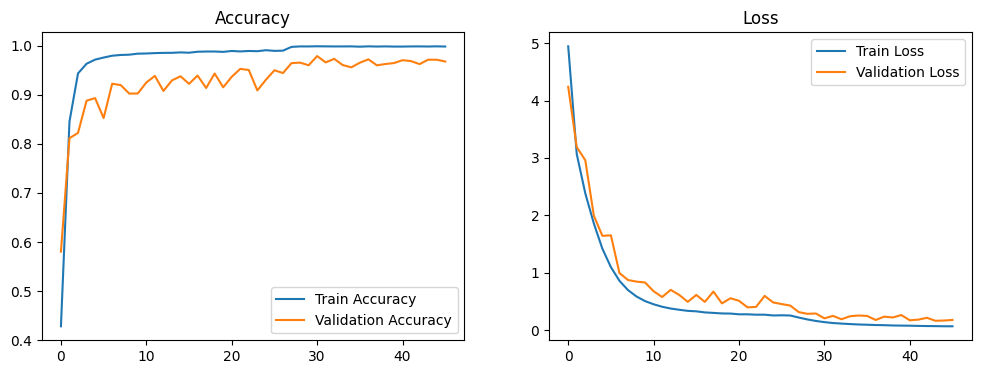

In [12]:
# Cell 2: Plot training history
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()
plt.show()


In [13]:
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

model = load_model('best_enhanced_model.h5')


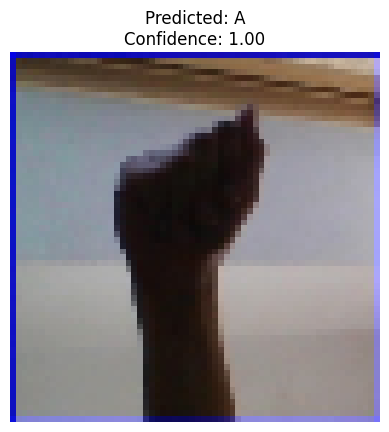

In [14]:
# Cell 3: Test prediction
import cv2
import numpy as np

def predict_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (64,64))
    img = img/255.0
    img = np.expand_dims(img, axis=0)
    
    pred = model.predict(img)
    class_idx = np.argmax(pred)
    confidence = np.max(pred)
    
    plt.imshow(img[0])
    plt.title(f"Predicted: {class_names[class_idx]}\nConfidence: {confidence:.2f}")
    plt.axis('off')
    plt.show()

# Test with sample image
predict_image("datasets/asl_alphabet_train/asl_alphabet_train/A/A1.jpg")


# Random Forest Classification

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, shuffle=True, stratify=labels)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()

model.fit(x_train, y_train)

y_predict = model.predict(x_test)

score = accuracy_score(y_predict, y_test)

print('{}% of samples were classified correctly !'.format(score * 100))

f = open('model.p', 'wb')
pickle.dump({'model': model}, f)
f.close()

In [6]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import joblib
import time

class ASLRecognizer:
    def __init__(self):
        self.model = None
        self.classes = None
        self.input_shape = None

    def load_data(self, data_dir, img_size=(64, 64), test_size=0.2, random_state=42):
        """
        Load ASL dataset from directory structure
        Expected structure:
        data_dir/
            asl_alphabet_train/
                class1/
                    img1.jpg
                    img2.jpg
                    ...
                class2/
                    ...
            asl_alphabet_test/
                class1/
                    img1.jpg
                    ...
                ...
        """
        X = []
        y = []
        
        # Get class names from train directory
        train_dir = os.path.join(data_dir, "asl_alphabet_train")
        self.classes = sorted(os.listdir(train_dir))
        if '.DS_Store' in self.classes:  # Remove macOS hidden file if present
            self.classes.remove('.DS_Store')
        
        print(f"Found {len(self.classes)} classes: {self.classes}")
        
        # Load training data
        print("Loading training data...")
        for class_name in self.classes:
            class_dir = os.path.join(train_dir, class_name)
            for img_name in os.listdir(class_dir):
                if img_name.endswith(('.jpg', '.jpeg', '.png')):
                    img_path = os.path.join(class_dir, img_name)
                    img = Image.open(img_path).convert('L')  # Convert to grayscale
                    img = img.resize(img_size)
                    img_array = np.array(img).flatten()  # Flatten image to 1D array
                    X.append(img_array)
                    y.append(class_name)
        
        # Convert to numpy arrays
        X = np.array(X)
        y = np.array(y)
        
        # Split into train and validation sets
        X_train, X_val, y_train, y_val = train_test_split(
            X, y, test_size=test_size, random_state=random_state
        )
        
        # Load test data if available
        test_dir = os.path.join(data_dir, "asl_alphabet_test")
        X_test = []
        y_test = []
        
        if os.path.exists(test_dir):
            print("Loading test data...")
            for class_name in self.classes:
                class_dir = os.path.join(test_dir, class_name)
                if os.path.exists(class_dir):
                    for img_name in os.listdir(class_dir):
                        if img_name.endswith(('.jpg', '.jpeg', '.png')):
                            img_path = os.path.join(class_dir, img_name)
                            img = Image.open(img_path).convert('L')
                            img = img.resize(img_size)
                            img_array = np.array(img).flatten()
                            X_test.append(img_array)
                            y_test.append(class_name)
            
            X_test = np.array(X_test)
            y_test = np.array(y_test)
        else:
            X_test, y_test = None, None
        
        self.input_shape = (img_size[0], img_size[1], 1)  # For reference
        
        return X_train, X_val, X_test, y_train, y_val, y_test

    def train(self, X_train, y_train, n_estimators=100, max_depth=None, random_state=42):
        """
        Train Random Forest classifier
        """
        print("Training Random Forest model...")
        start_time = time.time()
        
        self.model = RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            random_state=random_state,
            n_jobs=-1  # Use all available cores
        )
        
        self.model.fit(X_train, y_train)
        
        training_time = time.time() - start_time
        print(f"Training completed in {training_time:.2f} seconds")
        
        return self.model

    def evaluate(self, X, y, dataset_name="validation"):
        """
        Evaluate model performance
        """
        if self.model is None:
            raise ValueError("Model has not been trained yet")
        
        print(f"Evaluating on {dataset_name} set...")
        y_pred = self.model.predict(X)
        accuracy = accuracy_score(y, y_pred)
        print(f"{dataset_name} Accuracy: {accuracy:.4f}")
        print("\nClassification Report:")
        print(classification_report(y, y_pred, target_names=self.classes))
        
        return accuracy

    def save_model(self, filepath="asl_random_forest_model.pkl"):
        """
        Save trained model to file
        """
        if self.model is None:
            raise ValueError("Model has not been trained yet")
        
        joblib.dump({
            'model': self.model,
            'classes': self.classes,
            'input_shape': self.input_shape
        }, filepath)
        print(f"Model saved to {filepath}")

    def load_model(self, filepath="asl_random_forest_model.pkl"):
        """
        Load trained model from file
        """
        data = joblib.load(filepath)
        self.model = data['model']
        self.classes = data['classes']
        self.input_shape = data['input_shape']
        print(f"Model loaded from {filepath}")
        return self.model

    def predict(self, image):
        """
        Predict class for a single image
        """
        if self.model is None:
            raise ValueError("Model has not been trained or loaded")
        
        # Preprocess image (same as during training)
        if isinstance(image, str):  # If it's a filepath
            img = Image.open(image).convert('L')
        else:  # Assume it's a PIL Image
            img = image.convert('L')
        
        img = img.resize((self.input_shape[0], self.input_shape[1]))
        img_array = np.array(img).flatten().reshape(1, -1)
        
        # Predict
        pred_class = self.model.predict(img_array)[0]
        pred_proba = self.model.predict_proba(img_array)[0]
        
        return pred_class, pred_proba


def main():
    # Initialize recognizer
    recognizer = ASLRecognizer()
    
    # Path to your dataset directory
    data_dir = "Datasets"
    
    # Load and preprocess data
    X_train, X_val, X_test, y_train, y_val, y_test = recognizer.load_data(
        data_dir, img_size=(32, 32)  # Smaller size for faster training
    )
    
    # Train model
    recognizer.train(X_train, y_train, n_estimators=50, max_depth=20)  # Reduced parameters for faster training
    
    # Evaluate on validation set
    recognizer.evaluate(X_val, y_val, "validation")
    
    # Evaluate on test set if available
    if X_test is not None and y_test is not None:
        recognizer.evaluate(X_test, y_test, "test")
    
    # Save model
    recognizer.save_model()
    
    # Example prediction (using a random training sample)
    if len(X_train) > 0:
        sample_idx = np.random.randint(0, len(X_train))
        sample_img = X_train[sample_idx].reshape(32, 32)
        sample_img = Image.fromarray(sample_img)
        
        pred_class, pred_proba = recognizer.predict(sample_img)
        true_class = y_train[sample_idx]
        
        print(f"\nExample Prediction:")
        print(f"True class: {true_class}")
        print(f"Predicted class: {pred_class}")
        print(f"Probabilities: {dict(zip(recognizer.classes, pred_proba))}")


if __name__ == "__main__":
    main()

Found 29 classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']
Loading training data...
Loading test data...
Training Random Forest model...
Training completed in 8.30 seconds
Evaluating on validation set...
validation Accuracy: 0.9909

Classification Report:
              precision    recall  f1-score   support

           A       1.00      0.97      0.99       584
           B       0.96      0.97      0.97       574
           C       0.99      0.98      0.98       617
           D       0.96      0.99      0.98       589
           E       0.98      0.97      0.98       602
           F       0.99      1.00      0.99       580
           G       0.99      1.00      1.00       585
           H       1.00      0.99      1.00       587
           I       0.99      0.99      0.99       599
           J       1.00      1.00      1.00       598
           K       0.99      1.0

ValueError: Expected 2D array, got 1D array instead:
array=[].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [9]:
import os
import numpy as np
from PIL import Image
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import joblib
import time

class ASLRecognizer:
    def __init__(self):
        self.model = None
        self.classes = None
        self.input_shape = None

    def load_data(self, data_dir, img_size=(32, 32), test_size=0.2, random_state=42):
        """
        Load ASL dataset from directory structure
        """
        X = []
        y = []
        
        # Get class names from train directory
        train_dir = os.path.join(data_dir, "asl_alphabet_train")
        self.classes = sorted([d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))])
        
        print(f"Found {len(self.classes)} classes: {self.classes}")
        
        # Load training data
        print("Loading training data...")
        for class_idx, class_name in enumerate(self.classes):
            class_dir = os.path.join(train_dir, class_name)
            for img_name in os.listdir(class_dir):
                if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                    img_path = os.path.join(class_dir, img_name)
                    try:
                        img = Image.open(img_path).convert('L')  # Convert to grayscale
                        img = img.resize(img_size)
                        img_array = np.array(img).flatten()
                        if img_array.size > 0:  # Only add if we got valid data
                            X.append(img_array)
                            y.append(class_name)
                    except Exception as e:
                        print(f"Error loading {img_path}: {str(e)}")
        
        if not X:
            raise ValueError("No valid training images found!")
        
        X = np.array(X)
        y = np.array(y)
        
        # Split into train and validation sets
        X_train, X_val, y_train, y_val = train_test_split(
            X, y, test_size=test_size, random_state=random_state
        )
        
        # Load test data if available
        test_dir = os.path.join(data_dir, "asl_alphabet_test")
        X_test, y_test = None, None
        
        if os.path.exists(test_dir):
            print("Loading test data...")
            X_test = []
            y_test = []
            for class_name in self.classes:
                class_dir = os.path.join(test_dir, class_name)
                if os.path.exists(class_dir):
                    for img_name in os.listdir(class_dir):
                        if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                            img_path = os.path.join(class_dir, img_name)
                            try:
                                img = Image.open(img_path).convert('L')
                                img = img.resize(img_size)
                                img_array = np.array(img).flatten()
                                if img_array.size > 0:
                                    X_test.append(img_array)
                                    y_test.append(class_name)
                            except Exception as e:
                                print(f"Error loading {img_path}: {str(e)}")
            
            if X_test:
                X_test = np.array(X_test)
                y_test = np.array(y_test)
        
        self.input_shape = (img_size[0], img_size[1], 1)
        
        return X_train, X_val, X_test, y_train, y_val, y_test

    def train(self, X_train, y_train, n_estimators=50, max_depth=20, random_state=42):
        """
        Train Random Forest classifier
        """
        if X_train.size == 0:
            raise ValueError("Training data is empty!")
            
        print("Training Random Forest model...")
        start_time = time.time()
        
        self.model = RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            random_state=random_state,
            n_jobs=-1
        )
        
        self.model.fit(X_train, y_train)
        
        print(f"Training completed in {time.time() - start_time:.2f} seconds")
        return self.model

    def evaluate(self, X, y, dataset_name="validation"):
        """
        Evaluate model performance
        """
        if self.model is None:
            raise ValueError("Model has not been trained yet")
        if X.size == 0:
            print(f"Warning: {dataset_name} set is empty!")
            return 0.0
            
        print(f"Evaluating on {dataset_name} set...")
        y_pred = self.model.predict(X)
        accuracy = accuracy_score(y, y_pred)
        print(f"{dataset_name} Accuracy: {accuracy:.4f}")
        print("\nClassification Report:")
        print(classification_report(y, y_pred, target_names=self.classes))
        return accuracy

    def save_model(self, filepath="asl_random_forest_model.pkl"):
        """Save trained model to file"""
        if self.model is None:
            raise ValueError("Model has not been trained yet")
        joblib.dump({
            'model': self.model,
            'classes': self.classes,
            'input_shape': self.input_shape
        }, filepath)
        print(f"Model saved to {filepath}")

    def load_model(self, filepath="asl_random_forest_model.pkl"):
        """Load trained model from file"""
        data = joblib.load(filepath)
        self.model = data['model']
        self.classes = data['classes']
        self.input_shape = data['input_shape']
        print(f"Model loaded from {filepath}")
        return self.model

    def predict(self, image):
        """Predict class for a single image"""
        if self.model is None:
            raise ValueError("Model has not been trained or loaded")
        
        if isinstance(image, str):
            img = Image.open(image).convert('L')
        else:
            img = image.convert('L')
        
        img = img.resize((self.input_shape[0], self.input_shape[1]))
        img_array = np.array(img).flatten().reshape(1, -1)
        
        pred_class = self.model.predict(img_array)[0]
        pred_proba = self.model.predict_proba(img_array)[0]
        
        return pred_class, pred_proba


def main():
    recognizer = ASLRecognizer()
    data_dir = "Datasets"
    
    try:
        X_train, X_val, X_test, y_train, y_val, y_test = recognizer.load_data(data_dir)
        
        recognizer.train(X_train, y_train)
        recognizer.evaluate(X_val, y_val, "validation")
        
        if X_test is not None and y_test is not None:
            recognizer.evaluate(X_test, y_test, "test")
        
        recognizer.save_model()
        
        if len(X_train) > 0:
            sample_idx = np.random.randint(0, len(X_train))
            sample_img = X_train[sample_idx].reshape(recognizer.input_shape[0], recognizer.input_shape[1])
            sample_img = Image.fromarray(sample_img)
            
            pred_class, pred_proba = recognizer.predict(sample_img)
            print(f"\nExample Prediction:")
            print(f"True class: {y_train[sample_idx]}")
            print(f"Predicted class: {pred_class}")
            print("Probabilities:", {c: f"{p:.4f}" for c, p in zip(recognizer.classes, pred_proba)})
    
    except Exception as e:
        print(f"Error: {str(e)}")
        print("Please check:")
        print("1. Dataset directory structure is correct")
        print("2. Image files are valid and accessible")
        print("3. Required packages are installed")


if __name__ == "__main__":
    main()

Found 29 classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']
Loading training data...
Loading test data...
Training Random Forest model...
Training completed in 8.32 seconds
Evaluating on validation set...
validation Accuracy: 0.9909

Classification Report:
              precision    recall  f1-score   support

           A       1.00      0.97      0.99       584
           B       0.96      0.97      0.97       574
           C       0.99      0.98      0.98       617
           D       0.96      0.99      0.98       589
           E       0.98      0.97      0.98       602
           F       0.99      1.00      0.99       580
           G       0.99      1.00      1.00       585
           H       1.00      0.99      1.00       587
           I       0.99      0.99      0.99       599
           J       1.00      1.00      1.00       598
           K       0.99      1.0